<!-- <a href="https://colab.research.google.com/github/Robaina/Pynteny/blob/main/docs/examples/example_api_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> -->

<div style="text-align:center;">
<img src="https://user-images.githubusercontent.com/21340147/227912321-f76e622a-684d-48a9-8ead-9a2ce7caebe9.png" style="width:70%;"/>
</div>
<br/>

[Semidán Robaina](https://github.com/Robaina), February 2023.

In this Notebook, we will use MetaTag through its Python API to reconstruct a phylogenetic tree. To this end, we will use peptide sequences from the [MARref database](https://mmp2.sfb.uit.no/marref/) and a profile HMM to identify sequences beloging to the X gene.

- Note that we could have conducted the same search through Pynteny's command-line interface.

- Find more info in the [documentation pages](https://robaina.github.io/MetaTag/)!

Let's start by importing some required modules.

In [1]:
from pathlib import Path
from pandas import DataFrame
from metatag.cli import MetaTag
from metatag.visualization import make_tree_html
from metatag.pipelines import ReferenceTreeBuilder, QueryLabeller, QueryProcessor

Let's now create a directory to store results

In [2]:
tests_dir = Path("../../tests")
outdir = Path("example_api/results")
# outdir.mkdir(exist_ok=True, parents=True)

## Download Marref database:

Download the [MarRef](https://mmp2.sfb.uit.no/marref/) database and extract contents. We will use the `protein.faa` file, containing translated peptide sequences.

## Infering a gene-specific phylogenetic tree

We will infer a phylogenetic tree for the gene _nifH_. To this end, we will use the TIGRFAM profile HMM for this gene: [TIGR01287](), as well as [TIGR02016](), corresponding to gene _BCHX_ which serves as an outgroup. The class `ReferenceTreeBuilder` will take care of all necessary steps to infer the tree. Namely, (i) preprocess the input marref database, (ii) build a reference database containing a maximum of 20 nifH and 5 BCHX representative sequences, using both [CD-Hit]() and [RepSet](), (iii) align the reference sequences with [MUSCLE](), (iv) infer a phylogenetic tree from the alignment with [FastTree]().

In [3]:
tree_builder = ReferenceTreeBuilder(
    input_database=Path("/home/robaina/Databases/MAR_database/protein.faa"),
    hmms=[
        (tests_dir / "test_data" / "TIGR01287.1.HMM").as_posix(),
        (tests_dir / "test_data" / "TIGR02016.1.HMM").as_posix(),
    ],
    maximum_hmm_reference_sizes=[10, 5],
    relabel_prefixes=["ref_", "out_"],
    relabel=True,
    remove_duplicates=True,
    hmmsearch_args="--cut_ga",
    output_directory=outdir,
    msa_method="muscle",
    tree_method="fasttree",
    tree_model="JTT",
)
tree_builder.run()

2023-03-30 17:03:29,981 | INFO: Removing duplicates...


Here is the generated tree:

In [9]:
make_tree_html(tree_builder.reference_tree, output_dir=outdir / "tree_plot")

/home/robaina/miniconda3/envs/metatag-dev/lib/python3.10/site-packages/empress/tree.py:79: TreeFormatWarning: Internal node names in the tree are not unique.
  warnings.warn(


<a href="file:///home/robaina/Documents/MetaTag/docs/examples/example_api/tree_plot/empress.html" target="_blank"><img src="example_api/example_tree.png" style="width:50%;"></a>

## Preprocess metagenomic data

We need to first preprocess the metagenomic data to remove low quality reads as well as to prefilter sequences using the same profile HMM used to infer the phylogenetic tree. This will reduce the computational cost of the placement step.

In [4]:
processor = QueryProcessor(
    input_query=Path("/home/robaina/Databases/Uniprot/uniprot_sprot.fasta"),
    hmm=tests_dir / "test_data" / "TIGR01287.1.HMM",
    hmmsearch_args="--cut_ga",
    minimum_sequence_length=30,
    output_directory=outdir,
    relabel=True,
)
processor.run()


2023-03-30 16:59:54,366 | INFO: Removing duplicates...
2023-03-30 16:59:56,926 | INFO: Asserting correct sequence format...
2023-03-30 17:00:11,309 | INFO: Relabelling records...
2023-03-30 17:00:12,644 | INFO: Done!
2023-03-30 17:00:12,646 | INFO: Making peptide-specific reference database...
2023-03-30 17:00:12,647 | INFO: Processing hmm TIGR01287.1 with additional arguments: --cut_ga
2023-03-30 17:00:12,649 | INFO: Running Hmmer...
2023-03-30 17:00:13,524 | INFO: Parsing Hmmer output file...
2023-03-30 17:00:13,531 | INFO: Filtering Fasta...
2023-03-30 17:00:13,679 | INFO: Filtering sequences by established length bounds...
2023-03-30 17:00:13,688 | INFO: No reduction algorithm has been selected.
2023-03-30 17:00:13,709 | WARNING: Could not delete temporary files: [Errno 2] No such file or directory: '/tmp/tmperjbai4l'
2023-03-30 17:00:13,710 | INFO: Done!


## Place and label metagenomic data

2023-03-30 17:00:21,886 | INFO: Placing reads on tree...
2023-03-30 17:00:22,300 | INFO: Writing tree with placements...
2023-03-30 17:00:22,306 | INFO: Done!
2023-03-30 17:00:22,309 | INFO: Filtering placements by maximum distance: "pendant_diameter_ratio" of 1.0
2023-03-30 17:00:22,311 | INFO: Filtering placements for tree diameter: 2.5907704590000002
2023-03-30 17:00:22,314 | INFO: Filtering placements by minimum LWR of: 0.8
2023-03-30 17:00:22,624 | INFO: Done!
2023-03-30 17:00:22,626 | INFO: Counting labelled placements...
2023-03-30 17:00:22,941 | INFO: Done!
2023-03-30 17:00:22,943 | INFO: Relabelling tree...
2023-03-30 17:00:23,222 | INFO: Done!


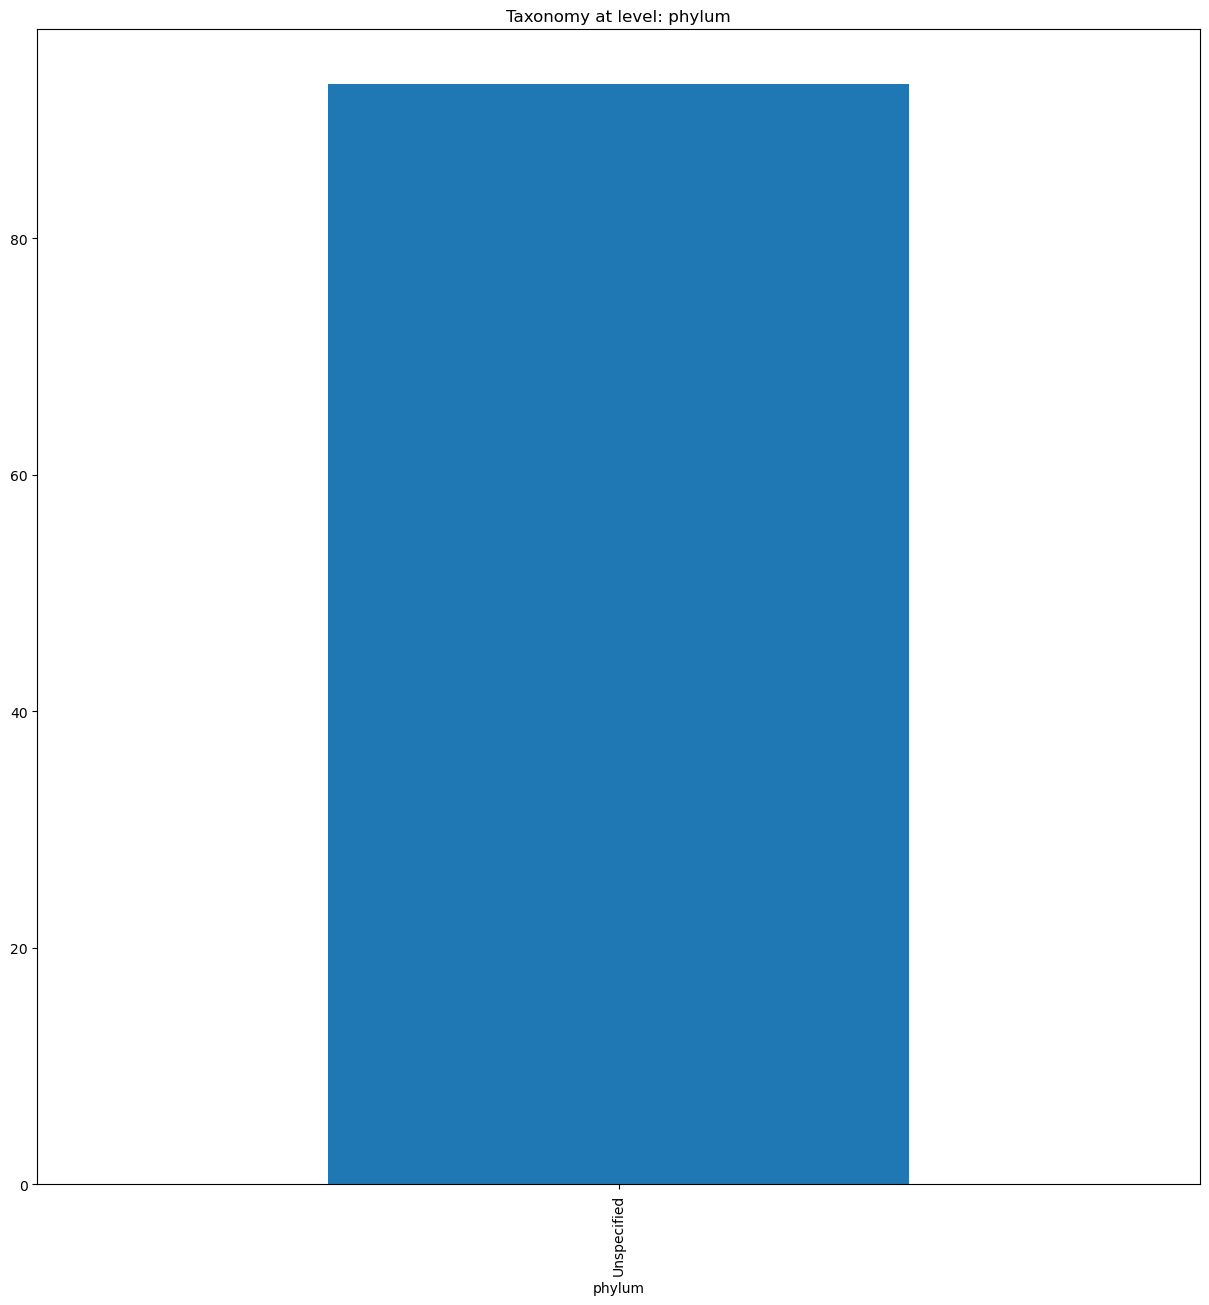

In [5]:
labeller = QueryLabeller(
    input_query=processor.filtered_query,
    skip_preprocessing=True,
    reference_alignment=tree_builder.reference_alignment,
    reference_tree=tree_builder.reference_tree,
    reference_labels=[
        tree_builder.reference_labels
    ],
    tree_model="JTT",
    # tree_clusters=tests_dir / "test_data" / "clusters.tsv",
    # tree_cluster_scores=tests_dir / "test_data" / "cluster_scores.tsv",
    # tree_cluster_score_threshold=0.6,
    alignment_method="papara",
    output_directory=outdir,
    maximum_placement_distance=1.0,
    distance_measure="pendant_diameter_ratio",
    minimum_placement_lwr=0.8,
)
labeller.run()

## Get citation

We can get the citation string by calling the `cite` method:

In [1]:
MetaTag.cite()

If you use this software, please cite it as below: 
Semidán Robaina Estévez (2022). MetaTag: Metagenome functional and taxonomical annotation through phylogenetic tree placement.(Version 0.1.0). Zenodo.
